# About Dataset

The data consists of MRI images. The data has four classes of images both in training as well as a testing set:

- Mild Demented

- Moderate Demented

- Non Demented

- Very Mild Demented


# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle

import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from IPython.display import display,clear_output

In [79]:
%config Completer.use_jedi = False

# Preprocessing

In [80]:
BASE_DIR = 'Alzheimer_s Dataset\\'
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [81]:
train =tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,validation_split=.2,subset='training',
                                                           seed=1337,image_size=IMAGE_SIZE,batch_size=64)

validatioin =tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,validation_split=.2,subset='validation',
                                                                 seed=1337,image_size=IMAGE_SIZE,batch_size=64)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [82]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
num_classes=len(class_names)
train.class_names=class_names
validatioin.class_names=class_names

In [83]:
from tensorflow.data.experimental import AUTOTUNE
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train=train.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validatioin=validatioin.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [84]:
#The following cell makes calling images from our dataset more efficient.

train= train.cache().prefetch(buffer_size=AUTOTUNE)
validatioin = validatioin.cache().prefetch(buffer_size=AUTOTUNE)

In [85]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [86]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [87]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [88]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [89]:
model = build_model()
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [90]:
history = model.fit(
   train,validation_data=validatioin,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],epochs=30
)

Epoch 1/30
65/65 [==============================] - 59s 855ms/step - loss: 1.2151 - auc: 0.7459 - val_loss: 11.7256 - val_auc: 0.6654 - lr: 0.0100
Epoch 2/30
65/65 [==============================] - 54s 823ms/step - loss: 0.9634 - auc: 0.8182 - val_loss: 1.9056 - val_auc: 0.5487 - lr: 0.0089
Epoch 3/30
65/65 [==============================] - 54s 838ms/step - loss: 0.9348 - auc: 0.8266 - val_loss: 16.2524 - val_auc: 0.6634 - lr: 0.0079
Epoch 4/30
65/65 [==============================] - 54s 829ms/step - loss: 0.9261 - auc: 0.8284 - val_loss: 2.1163 - val_auc: 0.5538 - lr: 0.0071
Epoch 5/30
65/65 [==============================] - 54s 829ms/step - loss: 0.8997 - auc: 0.8400 - val_loss: 1.2116 - val_auc: 0.6643 - lr: 0.0063
Epoch 6/30
65/65 [==============================] - 54s 829ms/step - loss: 0.9018 - auc: 0.8375 - val_loss: 1.1538 - val_auc: 0.7149 - lr: 0.0056
Epoch 7/30
65/65 [==============================] - 55s 844ms/step - loss: 0.8801 - auc: 0.8470 - val_loss: 3.6046 - val_a

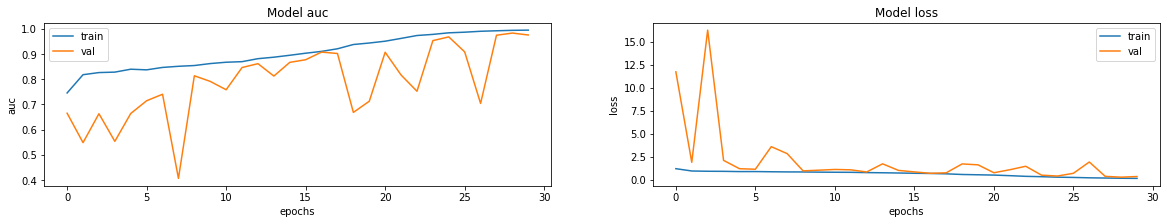

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [92]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset\\test",
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [110]:
model.evaluate(test_ds)

40/40 [==============================] - 4s 105ms/step - loss: 1.3397 - auc: 0.8590


[1.3396682739257812, 0.8589989542961121]

In [94]:
model.save('Alzheimer_model.h5')